# Data Preprocessing

## Modules Required for Data Preprocessing

In [13]:
!pip install annoy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Mounting the Google Drive

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Importing the modules used

In [15]:
import pandas as pd
import numpy as np
import random
import csv
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
from annoy import AnnoyIndex
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import cosine_distances

## Reading the tracks_features.csv

In [16]:
#Reading the Tracks_Features
data = pd.read_csv('/content/drive/Shareddrives/CMPE 256 Project/tracks_features.csv')

## Changing the labels of 'id' - "Strings----" To "Unique numbers"

In [17]:
data['id'] = data.index
#Extracting the features columns
features = ['acousticness', 'danceability', 'key', 'loudness', 'mode', 'tempo', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'valence']

#Creating the data_features Numpy Array
data_features = data[features].values

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1204025 entries, 0 to 1204024
Data columns (total 24 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   id                1204025 non-null  int64  
 1   name              1204025 non-null  object 
 2   album             1204025 non-null  object 
 3   album_id          1204025 non-null  object 
 4   artists           1204025 non-null  object 
 5   artist_ids        1204025 non-null  object 
 6   track_number      1204025 non-null  int64  
 7   disc_number       1204025 non-null  int64  
 8   explicit          1204025 non-null  bool   
 9   danceability      1204025 non-null  float64
 10  energy            1204025 non-null  float64
 11  key               1204025 non-null  int64  
 12  loudness          1204025 non-null  float64
 13  mode              1204025 non-null  int64  
 14  speechiness       1204025 non-null  float64
 15  acousticness      1204025 non-null  float64
 16  

In [19]:
data_features

array([[2.61e-02, 4.70e-01, 7.00e+00, ..., 3.56e-01, 7.27e-02, 5.03e-01],
       [1.29e-02, 5.99e-01, 1.10e+01, ..., 1.55e-01, 1.88e-01, 4.89e-01],
       [2.34e-02, 3.15e-01, 7.00e+00, ..., 1.22e-01, 4.83e-01, 3.70e-01],
       ...,
       [3.04e-02, 7.85e-01, 9.00e+00, ..., 6.64e-02, 5.64e-02, 4.67e-01],
       [6.97e-05, 6.65e-01, 6.00e+00, ..., 1.17e-01, 4.09e-02, 2.27e-01],
       [1.68e-02, 7.36e-01, 2.00e+00, ..., 2.79e-01, 5.39e-02, 2.04e-01]])

## Now using the Standard Scaler to scale the features of the data_features array

In [20]:
scaler = StandardScaler()
#Scaled data features
scaled_data_features = scaler.fit_transform(data_features)

## Creating the Trees using ANNOYIndex

In [21]:
#Number of trees in ANNOY Implementation
n_trees = 10
#Number of dimensions of each node in the Tree will contains i.e. length of the features
n_dimensions = len(features)
#Creating the AnnoyIndex
index = AnnoyIndex(n_dimensions, 'angular')

#Finding and adding them to the graph
for i, feature_vector in enumerate(scaled_data_features):
    index.add_item(i, feature_vector)

#Finally building the tree with the help of ANNOYIndex
index.build(n_trees)

True

In [22]:
len(scaled_data_features)

1204025

##Finding the nearest neighbours for using the algorithm ANNOY

In [23]:
n_neighbors = 20
#Creating the nearest neighbours dictionary for each songs and keeping that in the dictionary foramt
nearest_neighbors = {}
for i in range(len(scaled_data_features)):
    nearest_neighbors[i] = index.get_nns_by_item(i, n_neighbors)

In [24]:
#Creating the Mapped of track_id_to_index and index_to_track_id
track_id_to_index = {track_id: index for index, track_id in enumerate(data['id'])}
index_to_track_id = {index: track_id for track_id, index in track_id_to_index.items()}

##Creating the 500 playlist with the help of ANNOYIndex

In [25]:
# Create a list of the columns of having track features
track_features = ['acousticness', 'danceability', 'key', 'loudness', 'mode', 'tempo', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'valence']
#Creating the dicitonary 
track_features_dict={}
#Iterating through the data and mapping the features given as above with the track_ids which will be used for finding the feature vectors
for i, row in data.iterrows():
    #Extarcting the track_id
    track_id = row['id']
    #Extracting the features for that id
    features = {}
    for feature_name in track_features:
        features[feature_name] = row[feature_name]
    #Inclduing that features to the particular track_features_dict - dictionary
    track_features_dict[track_id] = features

In [26]:
# Function to generate a random playlist using AnnoyIndex
def generate_playlist(data, track_id_to_index, index_to_track_id, track_features_dict):
    #Randomly selecting the id
    seed_track_id = random.choice(data['id'].values)
    #Randomly selecting the playlist_length
    playlist_length = random.randint(5, 20)

    seed_index = track_id_to_index[seed_track_id]
    playlist_indices = [seed_index]

    #Adding the tracks and its features to the playlist
    playlist = []
    for i in range(playlist_length):
        track_id = index_to_track_id[playlist_indices[i]]
        features = track_features_dict[track_id]
        playlist.append({'id': track_id, **features})
        if i < playlist_length - 1:
            last_index = playlist_indices[-1]
            # Choose the first nearest neighbor that is not already in the playlist
            for neighbor in nearest_neighbors[last_index]:
                if neighbor not in playlist_indices:
                    next_index = neighbor
                    break
            playlist_indices.append(next_index)

    return playlist

In [27]:
# Generate 500 playlists
playlists = []
for i in range(500):
    playlist = generate_playlist(data, track_id_to_index, index_to_track_id, track_features_dict)
    #print(playlist)
    playlists.append(playlist)

In [28]:
# Calculate the mean feature values for each playlist for generating the playlist features
playlist_features = []
for i, playlist in enumerate(playlists, start=1):
    playlist_id = str(i)
    #Creating the playlist features
    features = {}
    #Extracting the track_ids stored in the particular playlist
    track_ids=[]
    for j in range(len(playlists[i-1])):
      track_ids.append(playlists[i-1][j]['id'])
    #print(len(track_ids))
    for feature_name in track_features:
        feature_values = [track[feature_name] for track in playlist]
        #Finding the mean values for each of the features for playlist
        mean_feature_value = sum(feature_values) / len(feature_values)
        features[feature_name] = mean_feature_value
    
    playlist_features.append({'playlist_id': playlist_id,'track_ids': track_ids, **features})

In [29]:
# Save the playlist features to a CSV file
with open('/content/drive/Shareddrives/CMPE 256 Project/playlist_features_500.csv', 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=['playlist_id', 'track_ids'] + track_features)
    writer.writeheader()
    for playlist in playlist_features:
        #print(playlist)
        writer.writerow(playlist)

## Saving the preprocessed_track_features to the csv after removing the unnecassary columns of the dataset

In [30]:
data_selected_cols = ['id','name','artists','acousticness', 'danceability', 'key', 'loudness', 'mode', 'tempo', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'valence']
data=data[data_selected_cols]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1204025 entries, 0 to 1204024
Data columns (total 14 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   id                1204025 non-null  int64  
 1   name              1204025 non-null  object 
 2   artists           1204025 non-null  object 
 3   acousticness      1204025 non-null  float64
 4   danceability      1204025 non-null  float64
 5   key               1204025 non-null  int64  
 6   loudness          1204025 non-null  float64
 7   mode              1204025 non-null  int64  
 8   tempo             1204025 non-null  float64
 9   energy            1204025 non-null  float64
 10  instrumentalness  1204025 non-null  float64
 11  liveness          1204025 non-null  float64
 12  speechiness       1204025 non-null  float64
 13  valence           1204025 non-null  float64
dtypes: float64(9), int64(3), object(2)
memory usage: 128.6+ MB


In [31]:
# save the dataframe to a CSV file
data.to_csv('/content/drive/Shareddrives/CMPE 256 Project/preprocessed_track_features.csv', index=False)

In [32]:
data.head()

,id,name,artists,acousticness,danceability,key,loudness,mode,tempo,energy,instrumentalness,liveness,speechiness,valence
0,0,Testify,['Rage Against The Machine'],0.02610,0.470,7,-5.399,1,117.906,0.978,0.000011,0.3560,0.0727,0.503
1,1,Guerrilla Radio,['Rage Against The Machine'],0.01290,0.599,11,-5.764,1,103.680,0.957,0.000071,0.1550,0.1880,0.489
2,2,Calm Like a Bomb,['Rage Against The Machine'],0.02340,0.315,7,-5.424,1,149.749,0.970,0.000002,0.1220,0.4830,0.370
3,3,Mic Check,['Rage Against The Machine'],0.16300,0.440,11,-5.830,0,96.752,0.967,0.000004,0.1210,0.2370,0.574
4,4,Sleep Now In the Fire,['Rage Against The Machine'],0.00162,0.426,2,-6.729,1,127.059,0.929,0.105000,0.0789,0.0701,0.539


In [33]:
fig = px.imshow(data.corr() ,text_auto=True, aspect="auto" , color_continuous_scale = "viridis")
fig.update_layout(title="Correlation Matrix of Song Features")
fig.show()

<ipython-input-33-30d1c0a9e58b>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  fig = px.imshow(data.corr() ,text_auto=True, aspect="auto" , color_continuous_scale = "viridis")


In [34]:
data.iloc[:, :-1].describe().T.sort_values(by='std' , ascending = False)\
                     .style.background_gradient(cmap='GnBu')\
                     .bar(subset=["max"], color='#BB0000')\
                     .bar(subset=["mean",], color='magenta')

,count,mean,std,min,25%,50%,75%,max
id,1204025.000000,602012.000000,347572.223268,0.000000,301006.000000,602012.000000,903018.000000,1204024.000000
tempo,1204025.000000,117.634352,30.937047,0.000000,94.054000,116.726000,137.046000,248.934000
loudness,1204025.000000,-11.808703,6.982132,-60.000000,-15.254000,-9.791000,-6.717000,7.234000
key,1204025.000000,5.194151,3.536731,0.000000,2.000000,5.000000,8.000000,11.000000
mode,1204025.000000,0.671459,0.469683,0.000000,0.000000,1.000000,1.000000,1.000000
acousticness,1204025.000000,0.446751,0.385201,0.000000,0.037600,0.389000,0.861000,0.996000
instrumentalness,1204025.000000,0.282861,0.376284,0.000000,0.000008,0.008080,0.719000,1.000000
energy,1204025.000000,0.509536,0.294684,0.000000,0.252000,0.524000,0.766000,1.000000
danceability,1204025.000000,0.493057,0.189669,0.000000,0.356000,0.501000,0.633000,1.000000
liveness,1204025.000000,0.201599,0.180459,0.000000,0.096800,0.125000,0.245000,1.000000


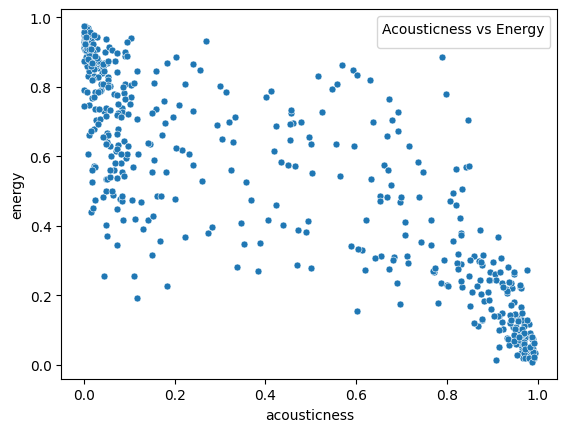

In [35]:
playlist_df = pd.read_csv("/content/drive/Shareddrives/CMPE 256 Project/playlist_features_500.csv")
g = sns.scatterplot(x='acousticness', y='energy', data=playlist_df, s=25)
g.legend(title='Acousticness vs Energy')
plt.show()

In [36]:
fig = px.imshow(playlist_df.corr() ,text_auto=True, aspect="auto" , color_continuous_scale = "viridis")
fig.update_layout(title="Correlation Matrix of Playlist Features")
fig.show()

<ipython-input-36-18dd6dfce35c>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



In [37]:
playlist_df.iloc[:, :-1].describe().T.sort_values(by='std' , ascending = False)\
                     .style.background_gradient(cmap='GnBu')\
                     .bar(subset=["max"], color='#BB0000')\
                     .bar(subset=["mean",], color='magenta')

,count,mean,std,min,25%,50%,75%,max
playlist_id,500.000000,250.500000,144.481833,1.000000,125.750000,250.500000,375.250000,500.000000
tempo,500.000000,118.349493,30.502122,0.000000,94.711657,118.527914,134.590028,203.559286
loudness,500.000000,-11.454983,6.758166,-36.610882,-14.876574,-9.029467,-6.346609,-3.632875
key,500.000000,5.077922,3.673817,0.000000,1.294444,5.000000,8.829186,11.000000
mode,500.000000,0.670000,0.470684,0.000000,0.000000,1.000000,1.000000,1.000000
acousticness,500.000000,0.423715,0.391448,0.000038,0.044894,0.277904,0.866525,0.993615
instrumentalness,500.000000,0.264143,0.384202,0.000000,0.002143,0.009097,0.776773,0.939846
energy,500.000000,0.527830,0.304016,0.007950,0.252218,0.568687,0.809808,0.974875
liveness,500.000000,0.209549,0.201868,0.012250,0.100432,0.113448,0.246872,0.955778
danceability,500.000000,0.509180,0.194610,0.000000,0.369367,0.529611,0.665358,0.929333


In [38]:
train_age = data.copy()
train_age["liveness"] = "Train"
ageDf = pd.concat([train_age])
fig = px.histogram(data_frame = data, 
                   x='liveness',
                   color= "liveness",
                   color_discrete_sequence =  ['#DE3163'],
                   marginal="box",
                   nbins= 100,
                    template="plotly_white"
                )
fig.update_layout(title = "Distribution of Liveness in Track Features Dataset" , title_x = 0.5)
fig.show()

Output hidden; open in https://colab.research.google.com to view.